# Fine-tuning BERT to answer SQuAD questions using TensorFlow2

## Overview

This notebook demonstrates how to:

* Download the SQuAD dataset using `tensorflow_datasets`
* Download a pretrain BERT model using `tensorflow_hub` and its corresponding `tokenizer`
* Process the squad dataset to:
  - Tokenize the contexts and questions
  - Pack each context+question pair into a tensorflow BERT input with
  - Identify the start and end token in the context
  - Convert the start/end context token index into the expected outputs
* Construct a model which converts the input into output predictions
* Choose a loss for each output
* Use the predictions to print out the answer
  - Find the highest probability start and end index

#### Table of contents

- [Setup notebook](#Setup-Notebook)
- [Setup dependencies](#Setup-dependencies)
- [Tokenizer](#Tokenizer)
- [Dataset](#Dataset)
- [Model](#Model)
- [Train](#Train)
- [Export](#Export)
- [Evaluate](#Evaluate)

## Setup notebook

Back to [Table of Contents](#Table-of-contents)

First you will need a machine with jupyter installed as well as a GPU/TPU.

One option to consider is to use [Google Colaboratory](https://research.google.com/colaboratory/).

This notebook was created with a [user-managed notebook](https://cloud.google.com/vertex-ai/docs/workbench/user-managed/create-new#gcloud) on Google Cloud's Vertex AI platform.

Create a notebook in your own project by going to https://notebook.new/ or else customizing the following command:

In [1]:
vm_image_project='deeplearning-platform-release'
vm_image_family='tf-ent-2-8-cu113-notebooks'
machine_type='n1-standard-8'
location='us-central1-a'
accelerator_type='CHOOSE' # eg, 'NVIDIA_TESLA_V100'
accelerator_cores=1

project='MY_PROJECT_ID'
instance_name='MY_INSTANCE_NAME'
print('Run the following command:')
print(' \\\n    '.join([
    f'  gcloud notebooks instances create {instance_name}',
    f'--project={project}',
    f'--vm-image-project={vm_image_project}',
    f'--vm-image-family={vm_image_family}',
    f'--machine-type={machine_type}',
    f'--location={location}',
    f'--accelerator_type={accelerator_type}',
    f'--accelerator_cores={accelerator_cores}',
]))

Run the following command:
  gcloud notebooks instances create MY_INSTANCE_NAME \
    --project=MY_PROJECT_ID \
    --vm-image-project=deeplearning-platform-release \
    --vm-image-family=tf-ent-2-8-cu113-notebooks \
    --machine-type=n1-standard-8 \
    --location=us-central1-a \
    --accelerator_type=CHOOSE \
    --accelerator_cores=1


Remember that these machines are expensive, many hundreds of dollars a month. So make sure you stop the VM when you are not using it, either at the [Vertex AI workbench](https://console.cloud.google.com/vertex-ai/workbench/list/instances) or else using `gcloud`:

In [2]:
print('Stop your notebook:')
print(f'  gcloud notebooks instances stop {instance_name} --project={project} --location={location}')
print('Delete your notebook:')
print(f'  gcloud notebooks instances delete {instance_name} --project={project} --location={location}')

Stop your notebook:
  gcloud notebooks instances stop MY_INSTANCE_NAME --project=MY_PROJECT_ID --location=us-central1-a
Delete your notebook:
  gcloud notebooks instances delete MY_INSTANCE_NAME --project=MY_PROJECT_ID --location=us-central1-a


After creating the notebook:
1) head over to the Vertex AI [workbench](https://console.cloud.google.com/vertex-ai/workbench/list/instances)
2) Wait for the `OPEN JUPYTERLAB` button to appear next the `MY_INSTANCE_NAME` you chose
3) Click on the button.

This should open JupyterLab, showing you a launcher tab. Click `File -> New Launcher` to create another one.

On the left side there should be a few buttons, one of which is a folder icon. Clicking this will close/open the file browser on the left sidebar.

This file browser should have a `+` button (which creates a new launcher tab) as well as an up arrow, which allows you to upload files. 

Click the upload button and upload this `.ipynb` python notebook. After uploading it should now appear in your file list.

Double-click the file you uploaded in the browser, and it should open this notebook. You are ready to go!

## Setup dependencies

Back to [Table of Contents](#Table-of-contents)

Make sure the following packages are installed:

In [3]:
!pip install -U "tensorflow-text==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 26.1 MB/s eta 0:00:0000:0100:01


In [4]:
# tf-models-official 2.8.0 produces a official.nlp.bert.configs below for some reasons, so use the previous version.
!pip install tf-models-official==2.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 25.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.8/99.8 KB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 19.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install pydot

In [6]:
!sudo apt install graphviz

E: Could not get lock /var/lib/dpkg/lock-frontend - open (11: Resource temporarily unavailable)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), is another process using it?


Now you can import all of the python modules that this notebook depends on

In [7]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
from official.nlp import optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

Additional imports that may be necessary

In [8]:
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa

A couple different strategies to use to distribute work, also helps move up some TF debug spew

In [9]:
default_strategy = tf.distribute.get_strategy()

In [10]:
if os.environ.get('COLAB_TPU_ADDR'):
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  # https://www.tensorflow.org/guide/distributed_training
  strategy = tf.distribute.MirroredStrategy()
  # TODO(fejta): strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
  # TODO(fejta): default_strategy = tf.distribute.get_strategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU


2022-05-01 01:03:35.817084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 01:03:35.986496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 01:03:35.987173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 01:03:35.988722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Tokenizer

Back to [Table of Contents](#Table-of-contents)

First let's download the BERT model we wil use. The [Choose a BERT model to fine-tune](https://www.tensorflow.org/text/tutorials/bert_glue#choose_a_bert_model_to_fine-tune) section of the GLUE fine-tuning (and similar tf BERT docs) contain a `Toggle code` button that lists other encoder/preprocessing pairs.

Let's choose the one with hyperparamers that match the BERT paper: 12 layers, 768 hidden features, 12 attention heads.

In [11]:
print('Select pretrained bert model')
# Pre-trained model
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
# Matching encoder
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
print(' ', tfhub_handle_encoder)

gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
print('Files in', gs_folder_bert)
gs_files = tf.io.gfile.listdir(gs_folder_bert)
print(' ', '\n  '.join(gs_files))

Select pretrained bert model
  https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Files in gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12
  bert_config.json
  bert_model.ckpt.data-00000-of-00001
  bert_model.ckpt.index
  vocab.txt


The `tfhub_handle_preprocess` does one-way preprocessing, which is going to be hard to work with. The SQuAD dataset returns a start index as well as the answer text. We will need to identify the matching tokens in the text and their start/end index.

Additionally, when we get predictions we will need to be able to convert a list of tokens back into text. Using [the BERT tokenizer](https://www.tensorflow.org/text/tutorials/fine_tune_bert#the_bert_tokenizer) section from the Fine-tuning BERT documentation provides a better way to do this, which we will copy:

In [12]:
print('Create reversible tokenizer')
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

Create reversible tokenizer


Let's define a couple helper functions to help us go between strings and tokens.

In [13]:
def to_token_ids(s):
    """Converts 'FUN stuffing' into ['fun', 'stuff', '##ing'] and then [7, 2089, 88]."""
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(s))

def from_token_ids(ids, lossy=True):
    """Converts [7, 2089, 88] into ['fun', 'stuff', '##ing'] and then 'fun stuff ##ing' or 'fun stuffing'."""
    s = ' '.join(tokenizer.convert_ids_to_tokens(ids))
    if lossy:
        s = s.replace('[CLS] ', '').replace(' [PAD]', '').replace(' [SEP]', '\n\n').replace(' ##', '')
    return s

Now let's try it out!

In [14]:
print('String to token id list:')
orig = 'This is a very interesting sentence.'
ids = to_token_ids(orig)
print(orig, 'becomes:', ids)
print('Token ids to string:')
s = from_token_ids(ids)
print(ids, 'becomes:', s)

String to token id list:
This is a very interesting sentence. becomes: [2023, 2003, 1037, 2200, 5875, 6251, 1012]
Token ids to string:
[2023, 2003, 1037, 2200, 5875, 6251, 1012] becomes: this is a very interesting sentence .


## Dataset

Back to [Table of Contents](#Table-of-contents)

The [SQuAD dataset](https://rajpurkar.github.io/SQuAD-explorer/) is a popular dataset that tests reading comprehension. People are given a wikipedia paragraph and a question about it. The goal is to highlight the correct answer in the text. 

The BERT paper mentions this as one of the fine-tuning exercises it does very well on, We will now try and replicate its results.

The `tensorflow_datasets` module [includes](https://www.tensorflow.org/datasets/catalog/squad) squad, which makes it easy to download and prepare for training.



In [15]:
print('Load squad from tfds...')
out = tfds.load('squad/v1.1', with_info=True, batch_size=-1) # -1 means whole dataset in mem
squad, info = out
print('Done!')

Load squad from tfds...
Dataset squad downloaded and prepared to /home/jupyter/tensorflow_datasets/squad/v1.1/3.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Done!


Let's take a look at what we got:

In [16]:
squad.keys(), squad['train'].keys()

(dict_keys([Split('train'), Split('validation')]),
 dict_keys(['answers', 'context', 'id', 'question', 'title']))

In [17]:
print(info)

tfds.core.DatasetInfo(
    name='squad',
    full_name='squad/v1.1/3.0.0',
    description="""
    Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.
    """,
    config_description="""
    Version 1.1.0 of SQUAD
    """,
    homepage='https://rajpurkar.github.io/SQuAD-explorer/',
    data_path='/home/jupyter/tensorflow_datasets/squad/v1.1/3.0.0',
    download_size=33.51 MiB,
    dataset_size=94.06 MiB,
    features=FeaturesDict({
        'answers': Sequence({
            'answer_start': tf.int32,
            'text': Text(shape=(), dtype=tf.string),
        }),
        'context': Text(shape=(), dtype=tf.string),
        'id': tf.string,
        'question': Text(shape=(), dtype=tf.string),
        'title': Text(shape=(), dtype=tf.string),


We will need to encode each question into the format expected by bert. This involves tokenizing the question and context, converting the tokens into numbers and then also including the word type and word mask inputs as well.

The GLUE fine-tuning tutorial shows how to do this dynamically with as part of the keras/tensorflow graph, but this seems takes up enough GPU ram that shrinks the batch size and increases training time. It also makes it harder to figure out the correct start/end index to train on.

So instead we are going to preprocess everything so that the input and expected outputs are easy to obtain.

A fun thing about SQuAD is that it appears to have been created by paying people to write questions. A small percentage of them are hilariously bad. For example here's one bad question:
> I couldn't could up with another question. But i need to fill this space because I can't submit the hit. 

There are also issues where the answer might be `2` and the dataset indicates the first character of `2019`, but the tokizer is usually word or word-piece based, not character based. So we won't find the correct answer at this location.

This is a small part of the data, so I set up some infrastructure to patch it with better answers, but eventually got bored. So now we'll just identify these as `SKIP` examples and then filter them out of the dataset we train/validate on.

Something to improve if you can!

In [18]:
def decode(t):
    """Decode a tensor string into printable one."""
    return t.numpy().decode('utf-8')

In [19]:
patches = {} # No patches, see -Copy1.ipynb, TODO(fejta): add these

In [20]:
# BERT uses [CLS] for the start and [SEP] separates the context and question
tok_cls, tok_sep = tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])
seq_length = 384
zeros = np.zeros(seq_length, int)
SKIP = (zeros, zeros, zeros), (-1, -1)

def tokenize_example(ex):
    """Returns a packed example after tokenizing the input/finding output."""
    context = ex['context']
    context_txt = decode(context)
    context_ids = to_token_ids(context_txt)
    question_ids = to_token_ids(decode(ex['question']))
    # TODO(fejta): handle impossible questions
    if 'answers' not in ex:  # Probably an example we are predicting.
        start_idx, end_idx = 0, 0
    else:  # Try and identify the start and end index.
        # Check if this is a patched example
        exid = decode(ex['id'])
        ctx_start, atext_txt = patches.get(exid, (None, None))
        if ctx_start and ctx_start < 0:  # patch says to SKIP
            return SKIP
        # Now identify where the answer appears in the context.
        atext_txt = atext_txt or decode(ex['answers']['text'][0])
        answer_ids = to_token_ids(atext_txt)
        if not ctx_start:
            astart = ex['answers']['answer_start']
            ctx_start = int(astart[0])
            if ctx_start == 1:
                ctx_start = 0
        ctx_left = context_txt[:ctx_start]
        left_ids = to_token_ids(ctx_left)
        start_idx = len(left_ids)
        end_idx = start_idx + len(answer_ids)
        context_answer_ids = context_ids[start_idx:end_idx]
        # Make sure have the answer
        if context_answer_ids != answer_ids:
            return SKIP           
    return pack_example(context_ids, question_ids, start_idx, end_idx)

def pack_example(context_ids, question_ids, start_idx, end_idx):
    """Returns a ((words, types, mask), (start, end) tuple given the inputs"""
    # Format is [CLS, CTX1, CTX2, ..., CTXN, SEP, Q1, Q2, ..., SEP, 0, 0, ...]
    # AKA, CLS token, context tokens, SEP token, question tokens, SEP token, padding.
    # The CLS and SEP tokens are special tokens BERT expects.
    # NOTE: the BERT paper puts the question before the context, but
    # this seems easier.
    words = [tok_cls] + context_ids + [tok_sep] + question_ids + [tok_sep]
    # NOTE: the BERT paper does something fancier here, we just SKIP inputs that
    # are too long for now.
    if len(words) > seq_length:
        return SKIP
    # The types input distinguishes context and question.
    types = [0] * (len(context_ids)+2) + [1] * (len(question_ids) + 1)
    # The mask input specifies non-padding tokens.
    masks = [1] * len(types)
    # Padding ensures that it is exactly seq_length.
    pad_len = seq_length - len(masks)
    padding = [0] * pad_len
    types += padding
    masks += padding
    words += padding
    # Sanity check the input
    assert len(words) == len(types) == len(masks) == seq_length
    if start_idx or end_idx:
        # Sanity check the output
        assert start_idx >= 0 and end_idx >= 0, (start_idx, end_idx)
        assert start_idx < seq_length
        assert end_idx < seq_length
        ans_start = start_idx + 1
        ans_end = end_idx + 1
    else:
        ans_start = -1
        ans_end = -1
    return (words, types, masks), (ans_start, ans_end)

In [21]:
def yield_examples(ds, stop=None):
    for (i, ex) in enumerate(ds):
        if i % 1000 == 0:
            print(i, end=' ', flush=True)
        if i == stop:
            print('Stopping early')
            break
        yield tokenize_example(ex)
    print('Done!')

##### Add labels

In [22]:
def process_examples(*a, **kw):
    """Returns an input, output for each example in the dataset."""
    inputs = []
    labels = []
    for x, y in yield_examples(*a, **kw):
        inputs.append(x)
        labels.append(y)
    i = tf.constant(inputs, tf.int32)
    words, types, masks = tf.unstack(tf.transpose(i, [1,0,2]))
    l = tf.constant(labels)
    starts, ends = tf.unstack(tf.transpose(l, [1, 0]))
    assert len(words) == len(starts)
    return {
        'input_word_ids': words,
        'input_type_ids': types,
        'input_mask': masks,
    }, {
        'label_start': starts,
        'label_end': ends,
    }

Now let's process the dataset to generate our expected inputs and outputs.

If we look into the squad dataset, we'll find a dictionary that eventually returns a tensor of keys, for example:

In [23]:
squad['train']['question']

<tf.Tensor: shape=(87599,), dtype=string, numpy=
array([b'What is one use that would require an antenna to receive signals in various ways at once?',
       b'About how many counts existed in the Carolingian Empire?',
       b'How can climate changes be determined from soil?', ...,
       b"Guests attending the Queen's Garden Parties will mostly likely see which room?",
       b'What does a candidate swear on?',
       b'In what geographic part of Libya is Bani Walid located?'],
      dtype=object)>


Let's first pack the tensors into a dataset, which will reshape things from a single dictionary with many items in each key:

```
{
  'x': [1,2,3,...],
  'y': [10,11,12,...],
}
```

Into a list of dictionaries with a single item in each key:

```
[
  {'x': [1], 'y': [10]},
  {'x': [2], 'y': [11]},
  ...
]
```

In [24]:
print('Pack the dictionary of tensors into an iterable dataset')
raw_train_ds = tf.data.Dataset.from_tensor_slices(squad['train'])
raw_valid_ds = tf.data.Dataset.from_tensor_slices(squad['validation'])

Pack the dictionary of tensors into an iterable dataset


Now they are in the format our processing functions from above expects, so lets generate all the inputs and outputs:

In [25]:
print('Computing validation labels')
valid_stop = None # 1000 to get started
valid_x, valid_y = process_examples(raw_valid_ds, stop=valid_stop)

Computing validation labels
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 Done!


In [26]:
print('Computing training labels')
train_stop = None # 10000 to get started
train_x, train_y = process_examples(raw_train_ds, stop=train_stop)

Computing training labels
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 Done!


Lets also define a function that is able to decode the input/output into a format that's easier for a person to read:

In [27]:
def decode_x(xs, ys=None, trueys=None, stop=None):
    """Decodes each x (and optional y, ground truth y) and prints it."""
    lastctx = None  # Try and avoid repeating the same question.
    for i, toks in enumerate(xs['input_word_ids']):
        toks = toks.numpy()
        q = from_token_ids(toks)
        ctx = q.split('\n')[0]
        if lastctx and lastctx == ctx:
            q = '\n'.join(q.split('\n')[1:])
        else:
            if lastctx:
                print('-'*40)
            lastctx = ctx
        if ys or trueys:
            q = q and q[:-2]
        if ys:
            q += ' ' + answer(toks, ys, i)
        if trueys:
            a = answer(toks, trueys, i)
            q += f' (GTRUTH: {a})'
        print(q)
        if i == stop:
            break

            
def answer(toks, ys, i):
    """Returns the answer extracted from the input tokens."""
    s, e = ys['label_start'][i], ys['label_end'][i]
    return from_token_ids(toks[s:e])

Let's check an example from each dataset split:

In [28]:
print('Training example')
print('='*80)
decode_x(train_x,train_y, stop=1)
print('Validation example')
print('='*80)
decode_x(valid_x, valid_y, stop=1)

Training example
the difference in the above factors for the case of θ = 0 is the reason that most broadcasting ( transmissions intended for the public ) uses vertical polarization . for receivers near the ground , horizontally polarized transmissions suffer cancellation . for best reception the receiving antennas for these signals are likewise vertically polarized . in some applications where the receiving antenna must work in any position , as in mobile phones , the base station antennas use mixed polarization , such as linear polarization at an angle ( with both vertical and horizontal components ) or circular polarization .

 what is one use that would require an antenna to receive signals in various ways at once ? mobile phones
----------------------------------------
the coronation of charlemagne as emperor on christmas day 800 is regarded as a turning point in medieval history , marking a return of the western roman empire , since the new emperor ruled over much of the area prev

Now let's package things back up into a format that is easy to send to our model:

In [29]:
train_ds = tf.data.Dataset.from_tensor_slices({'x': train_x, 'y': train_y})
valid_ds = tf.data.Dataset.from_tensor_slices({'x': valid_x, 'y': valid_y})

And now filter our the bad examples:

In [30]:
print('Dropping bad examples')
ignore_rejects = lambda ex: ex['y']['label_end']>=0
filt_valid_ds = valid_ds.filter(ignore_rejects)
filt_train_ds = train_ds.filter(ignore_rejects)

Dropping bad examples


We are now ready to construct our model!

## Model

Back to [Table of Contents](#Table-of-contents)

Fine-tuning BERT is fairly easy, which is one of its primary innovations.
The architecture will send the inputs through BERT and get the sequence output,
which represents an embedding for each input token.

In addition to `sequence_output` there is also `pooled_output` and `encoder_output`, see [Using the BERT model](https://www.tensorflow.org/text/tutorials/classify_text_with_bert#using_the_bert_model) in Classify text with BERT for info about these outputs. We want the `sequence_output` because we want to make a prediction for each token and pick the best one.

These embeddings then get sent to a start and and end output that gets flattened.
The flattend outputs are then sent to [softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax), which can represent the probability that
the start/end is at this token.

Later we will use `np.argmax` to identify the index with the highest probability and
chooes that for our answer.

In [31]:
# Who knows what this does! But AUTO sounds promising so haven't bothered to figure it out
AUTOTUNE = tf.data.AUTOTUNE

def softmax(name, inp):
    # The input here will be something like (seq_length, hidden)
    # So we'll wind up doing (seq_len, hidden) * (hidden, 1)
    # and wind up with (seq_len, 1), aka an output for each
    # position in the input sequence.
    net = tf.keras.layers.Dense(1, name=name, use_bias=False)(inp)
    # Flatten this, aka change (seq_len, 1) to (seq_len,)
    net = tf.keras.layers.Flatten()(net)
    # Now apply softmax, aka an S-ish shape with a min of 0 and max of 1
    net = tf.keras.layers.Activation(tf.keras.activations.softmax)(net)
    return net
    
def build_highlighter_model():
    
    sentence_features = [
      'input_word_ids',
      'input_type_ids',
      'input_mask',
    ]
    # Input tells the network what it should expect.
    # The (None,) here that it will be* a rank 1 tensor of integers
    # This represents the input token ids, and should match seq_length
    # of 384
    # 
    # *: actually this should be a batch of rank 1 tensors, making this
    # a rank two tensor of (batch_size, seq_length).
    inp = {
        ft: tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name=ft)
        for ft in sentence_features
    }
    # This handle is a URL to a pretrained BERT model.
    # It will cause tensorflow_hub load the right architecture
    # And preconfigure all the weights.
    encodings = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT')(inp)
    # 
    net = encodings['sequence_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    start = softmax('start_logit', net)
    end = softmax('end_logit', net)
    # so they have a name
    outs = {
        'label_start': tf.keras.layers.Lambda(tf.identity, name='start_pos')(start),
        'label_end': tf.keras.layers.Lambda(tf.identity, name='end_pos')(end),
    }
    return tf.keras.Model(inputs=inp, outputs=outs, name='highlighter')

Now let's construct the model!

In [32]:
highlighter = build_highlighter_model()

Let's see what it looks like

Model: "highlighter"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 BERT (KerasLayer)              {'default': (None,   109482241   ['input_mask[0][0]',             
                                768),                             'input_type_ids[0][0]'

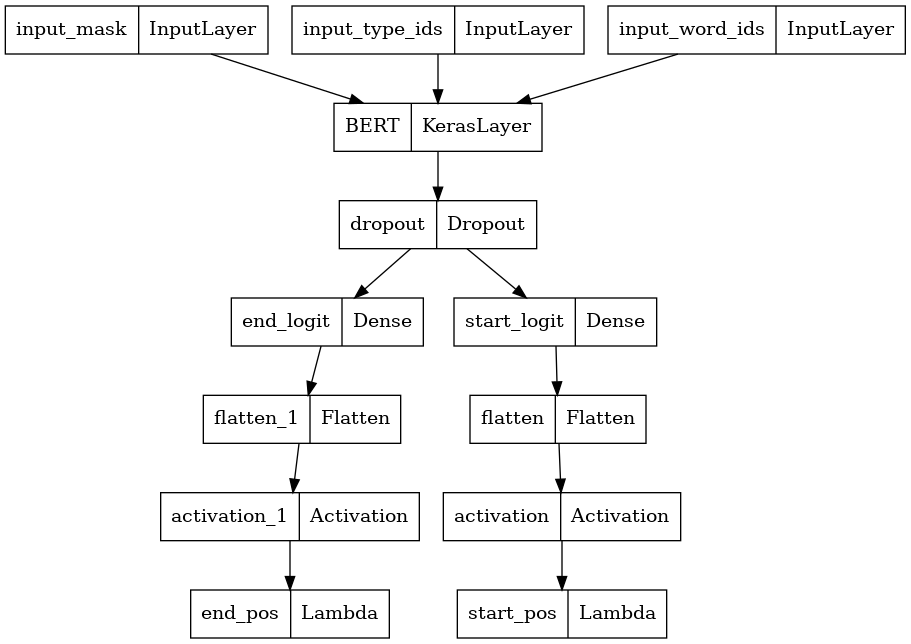

In [33]:
highlighter.summary()
tf.keras.utils.plot_model(highlighter)

Let's try it out!

In [34]:
for ex in filt_valid_ds.batch(1):
    predy = highlighter(ex['x']) # Print this to see the prediction for all 384 positions
    print(np.argmax(predy['label_start']), np.argmax(predy['label_end']))
    break

124 298


## Train

Back to [Table of Contents](#Table-of-contents)

These will just be random values, now we need to train it to do a better job.

The goal of the network is, for example, for the network to predict a start index of 7 and and end index of 15.

Ideally this means the start probability at position 7 should be 1 (and everything else 0), and the end probability at position 15 is 1 (and everywhere else zero).

The [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) loss function matches that goal. It is similar to [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) except that we can just specify `7` and `15` instead of a [one-hot](https://www.tensorflow.org/api_docs/python/tf/one_hot) encoded vector (1 at index 7 and 0 everywhere else).

We also make sure to shuffle the training dataset and map the inputs/outputs to what a tensorflow model [expects](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), namely an `(x,y)` tuple.

In [35]:
def prepare_ds(dataset, batch_size, training):
    num_examples = len(list(dataset)) # Maybe there's a faster way to do this...
    if training:
        dataset = dataset.shuffle(num_examples)
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda ex: (ex['x'], ex['y']))
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset, num_examples


def train(model, batch_size, epochs, init_lr):
    print('Preparing validation data...')
    vds, valid_len = prepare_ds(filt_valid_ds, batch_size, training=False)
    print('Preparing training data...')
    tds, train_len = prepare_ds(filt_train_ds, batch_size, training=True)
    steps_per_epoch = train_len / batch_size
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = num_train_steps / 10
    validation_steps = valid_len / batch_size
    print('Ready to train!')
    
    with default_strategy.scope():
        optimizer = optimization.create_optimizer(
            init_lr=init_lr,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            optimizer_type='adamw',
        )

        loss = {
            'label_start': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'label_end': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        }

        metrics = ['accuracy']

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        model.fit(
            x=tds,
            validation_data=vds,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_steps=validation_steps,
        )

    

Now we are ready to run our training program, choosing a couple of hyperparameters:
* `epochs`: how many times the model should see each training data
  - We choose `3`, matching the BERT paper
* `batch_size`: how many examples to compute in each mini-batch
  - largely constrained by GPU RAM
  - We choose `16` instead of `32` that the BERT paper uses
* `init_lr`: the initial learning rate, which controls how fast it adjusts weights
  - Choose `5e-5` to match the BERT paper
  
Each epoch takes around `1h` to complete on the full dataset.

NOTE: you can open up a terminal and use `nvidia-smi -l` to monitor stats about the GPU.

In [36]:
train(
    model=highlighter,
    epochs=3,
    batch_size=16,
    init_lr=5e-5,
)

Preparing validation data...
Preparing training data...
Ready to train!
Epoch 1/3
5404/5404 [==============================] - 2563s 471ms/step - loss: 3.0519 - end_pos_loss: 1.5083 - start_pos_loss: 1.5436 - end_pos_accuracy: 0.6069 - start_pos_accuracy: 0.5846 - val_loss: 1.9796 - val_end_pos_loss: 0.9585 - val_start_pos_loss: 1.0210 - val_end_pos_accuracy: 0.7285 - val_start_pos_accuracy: 0.6936
Epoch 2/3
5404/5404 [==============================] - 2544s 471ms/step - loss: 1.5042 - end_pos_loss: 0.7115 - start_pos_loss: 0.7927 - end_pos_accuracy: 0.7868 - start_pos_accuracy: 0.7514 - val_loss: 1.9589 - val_end_pos_loss: 0.9489 - val_start_pos_loss: 1.0100 - val_end_pos_accuracy: 0.7375 - val_start_pos_accuracy: 0.7049
Epoch 3/3
5404/5404 [==============================] - 2547s 471ms/step - loss: 0.8887 - end_pos_loss: 0.4112 - start_pos_loss: 0.4775 - end_pos_accuracy: 0.8675 - start_pos_accuracy: 0.8377 - val_loss: 2.2509 - val_end_pos_loss: 1.0983 - val_start_pos_loss: 1.1526 - 

2022-05-01 03:18:32.290384: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Export

We are done! Let's first save the model so we can reload/distribute it later.

In [37]:
def save_model(tfds_name='squad'):
    main_save_path = './my_models'
    bert_type = tfhub_handle_encoder.split('/')[-2]
    saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

    saved_model_path = os.path.join(main_save_path, saved_model_name)

    print('Saving', saved_model_path)

    # Save everything on the Colab host (even the variables from TPU memory)
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    highlighter.save(saved_model_path, include_optimizer=True,options=save_options)
    return saved_model_path
    

In [38]:
saved_model_path = save_model()

Saving ./my_models/squad_bert_en_uncased_L-12_H-768_A-12


2022-05-01 03:18:34.449046: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./my_models/squad_bert_en_uncased_L-12_H-768_A-12/assets


INFO:tensorflow:Assets written to: ./my_models/squad_bert_en_uncased_L-12_H-768_A-12/assets


In [39]:
with tf.device('/job:localhost'):
    default_model_path = './my_models/squad_bert_en_uncased_L-12_H-768_A-12'
    reloaded_model = tf.saved_model.load(globals().get('saved_model_path', default_model_path))

## Evaluate

Back to [Table of Contents](#Table-of-contents)

Let's write a function to see how our model performs:

In [40]:
def evaluate(xs, true_ys=None, stop=None, batch=16, model=reloaded_model):
    ds = tf.data.Dataset.from_tensor_slices({'x': xs, 'y': true_ys}).batch(batch)
    for i, batch in enumerate(ds):
        x = batch['x']
        pred = model(x)
        y = {k: np.argmax(pred[k], 1) for k in ['label_start', 'label_end']}
        true_y = batch.get('y')
        if i == 0:
            print('INPUT')
            print(ex)
            print('RAW OUTPUT PREDICTIONS')
            print(pred)
            print('ARGMAX OUTPUT')
            print(y) 
            print('='*40)
        decode_x(x, y, true_y)
        if i == stop:
            print('Stopping early')
            break
    else:
        print('Done!')

Let's first try it on the examples it trained about:

In [41]:
print('Training example')
print('='*80)
evaluate(train_x,train_y, stop=1, batch=4)

Training example
INPUT
{'x': {'input_word_ids': <tf.Tensor: shape=(1, 384), dtype=int32, numpy=
array([[  101,  1996, 11130,  5402,  4627,  2011,  2478,  1996,  9007,
        14548,  2483,  3597,  2000,  8081,  2522,  2475,  2046,  2274,
         1011,  6351, 19395, 18845,  3366, 20377,  8458,  2891, 24556,
         1006, 14548,  2361,  1007, 10737,  1012,  1996,  2765,  2003,
        14480,  2416,  1011,  6351, 10737,  2008,  3202,  3338,  2091,
         2046,  2093,  1011,  6351, 10737,  2170,  1017,  1011,  6887,
         2891,  8458,  8649,  2135, 17119,  2594,  5648,  1010,  2030,
         1017,  1011, 14198,  1012,  1996, 12649,  1998, 23233,  8458,
         2081,  1999,  1996,  2422,  9597,  2003,  2109,  2000, 10463,
         1996,  1017,  1011, 14198,  2046,  1043,  2135, 19357, 17920,
        10536,  3207,  1011,  1017,  1011, 17344,  1010,  2030,  1043,
         2509,  2361,  5699, 10737,  1012,  2087,  1997,  1996,  1043,
         2509,  2361, 10737,  2024, 22207,  2067,  2

Now let's see how it does against the validation data it never saw:

In [42]:
print('Validation example')
print('='*80)
evaluate(valid_x, valid_y, stop=1, batch=4)

Validation example
INPUT
{'x': {'input_word_ids': <tf.Tensor: shape=(1, 384), dtype=int32, numpy=
array([[  101,  1996, 11130,  5402,  4627,  2011,  2478,  1996,  9007,
        14548,  2483,  3597,  2000,  8081,  2522,  2475,  2046,  2274,
         1011,  6351, 19395, 18845,  3366, 20377,  8458,  2891, 24556,
         1006, 14548,  2361,  1007, 10737,  1012,  1996,  2765,  2003,
        14480,  2416,  1011,  6351, 10737,  2008,  3202,  3338,  2091,
         2046,  2093,  1011,  6351, 10737,  2170,  1017,  1011,  6887,
         2891,  8458,  8649,  2135, 17119,  2594,  5648,  1010,  2030,
         1017,  1011, 14198,  1012,  1996, 12649,  1998, 23233,  8458,
         2081,  1999,  1996,  2422,  9597,  2003,  2109,  2000, 10463,
         1996,  1017,  1011, 14198,  2046,  1043,  2135, 19357, 17920,
        10536,  3207,  1011,  1017,  1011, 17344,  1010,  2030,  1043,
         2509,  2361,  5699, 10737,  1012,  2087,  1997,  1996,  1043,
         2509,  2361, 10737,  2024, 22207,  2067, 

Now let's try some really random data it has not seen. Here is a paragraph taken from the [spyglass](https://github.com/kubernetes/test-infra/tree/master/prow/spyglass) and its [lens](https://github.com/kubernetes/test-infra/blob/master/prow/spyglass/write-a-lens.md) documentation for [prow](https://github.com/kubernetes/test-infra/tree/master/prow) as well as [testgrid](https://github.com/GoogleCloudPlatform/testgrid).

In [43]:
# Helper function to help write multiple questions about a single context paragraph.
def user_dataset(contexts):
    """Converts a [(ctx, (q1, q2, q3)), ...] into [{'context': ctx, 'question': q1}]."""
    for context, questions in contexts:
        for q in questions:
            yield {'context': context, 'question': q}
            
user_ds = user_dataset([
    (
        '''
        Spyglass is a pluggable artifact viewer framework for Prow.
        It collects artifacts (usually files in a storage bucket) from various sources and distributes them to registered viewers,
        which are responsible for consuming them and rendering a view.
        ''',
        (
            'What does spyglass collect?',
            'Where does spyglass collect artifacts from?',
            'What is spyglass?',
            'What are the registered viewers responsible for?',
            'What is spyglass a framework for?',
        ),
    ),
    (
        '''
        The HTML generated by a lens can reference static assets that will be served by Deck on behalf of your lens.
        Scripts and stylesheets can be referenced in the output of the Header() function
        (which is inserted into the <head> element).
        Relative references into your directory will work:
          spyglass adds a <base> tag that references the expected output directory.
        
        Spyglass lenses have access to a spyglass global that provides a number of APIs
        to interact with your lens backend and the rest of the world.
        Your lens is rendered in a sandboxed iframe, so you generally cannot interact without using these APIs.
        ''',
        (
            'What can lenses reference?',
            'What serves the HTML generated by the lens?',
            'How do relative references work?',
            'What provides the spyglass APIs?',
            'What do the spyglass APIs allow?',
            'Where is your lens rendered?',
        ),
    ),
    (
        '''
        Fragment URLs (the part after the #) are supported fairly transparently, despite being in an iframe.
        The parent page muxes all the lens's fragments and ensures that if the page is loaded,
        each lens receives the fragment it expects.
        Changing your fragment will automatically update the parent page's fragment.
        If the fragment matches the ID or name of an element, the page will scroll such that that element is visible.

        Anchor links (<a href="#something">) would usually not work well in conjunction with the <base> tag.
        To resolve this, we rewrite all links of this form to behave as expected both on page load and on DOM modification.
        In most cases, this should be transparent.
        If you want users to copy links via right click -> copy link, however, this will not work nicely.
        Instead, consider setting the href attribute to something from spyglass.makeFragmentLink,
        but handling clicks by manually setting location.hash to the desired fragment.
        ''',
        (
            'What is a fragment URL?',
            'When a fragment matches the ID, what does the page do?',
            'How well does copying via right click work?',
            'What should you set the href attribute to?',
        ),
    ),
    (
        '''
        The three sizes are Standard, Compact, and Super Compact.
        You can also specify width=X in the URL (X > 3) to customize the width.
        For small widths, this may mean the date and/or changelist, or other custom headers, are no longer visible.
        ''',
        (
            'How many sizes are there?',
            'How do you customize the width?',
            'What might happen when the width is small?',
        ),
    ),
])

Note that there are no known answers to the questions above. How well will it answer these questions?

Let's repackage and process the above questions into a `user_x` and `user_y` that we can send into evaluate.

In [44]:
def repackage():
    out = {}
    for ex in user_ds:
        for key in ex:
            out.setdefault(key, []).append(ex[key])
            
    return out


raw_user_ds = tf.data.Dataset.from_tensor_slices(repackage())
user_x, user_y = process_examples(raw_user_ds)

user_ds = tf.data.Dataset.from_tensor_slices({'x': user_x})

0 Done!


Now let's see it's predictions!

In [45]:
evaluate(user_x)

INPUT
{'x': {'input_word_ids': <tf.Tensor: shape=(1, 384), dtype=int32, numpy=
array([[  101,  1996, 11130,  5402,  4627,  2011,  2478,  1996,  9007,
        14548,  2483,  3597,  2000,  8081,  2522,  2475,  2046,  2274,
         1011,  6351, 19395, 18845,  3366, 20377,  8458,  2891, 24556,
         1006, 14548,  2361,  1007, 10737,  1012,  1996,  2765,  2003,
        14480,  2416,  1011,  6351, 10737,  2008,  3202,  3338,  2091,
         2046,  2093,  1011,  6351, 10737,  2170,  1017,  1011,  6887,
         2891,  8458,  8649,  2135, 17119,  2594,  5648,  1010,  2030,
         1017,  1011, 14198,  1012,  1996, 12649,  1998, 23233,  8458,
         2081,  1999,  1996,  2422,  9597,  2003,  2109,  2000, 10463,
         1996,  1017,  1011, 14198,  2046,  1043,  2135, 19357, 17920,
        10536,  3207,  1011,  1017,  1011, 17344,  1010,  2030,  1043,
         2509,  2361,  5699, 10737,  1012,  2087,  1997,  1996,  1043,
         2509,  2361, 10737,  2024, 22207,  2067,  2046, 14548,  2361

Not too bad!

## Next steps

* Get this to run with TPUs instead of GPUs.
* Add an [F1 metric](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1)
  - A tensorflow [addon for F1](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score)
  - SQuADs [F1 score](https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/) script
    - Submissions are evaluated using this metric
  - Tensorflow callback [on_epoc_end](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback#on_epoch_end)
* Update for SQuAD v2 with unanswerable questions
  - Make unanswerable target the `[CLS]` position
  - [Example](https://qa.fastforwardlabs.com/no%20answer/null%20threshold/bert/distilbert/exact%20match/f1/robust%20predictions/2020/06/09/Evaluating_BERT_on_SQuAD.html#F1) of this activity.
* Apply this knowledge to a prow highlighter
  - Split document into N pages
  - Tokenize each page
  - Find the `start, end` token position of each highlight (or `0,0` if no highlight)
  - Send tokenized page to BERT
  - Send BERT `sequence_output` to `start` and `end` `Dense(1)` outputs that gets flattened and softmaxed
  - Choose the highest probability start/end combo.


## References

* BERT paper - https://arxiv.org/abs/1810.04805
* [Fine tuning BERT](https://www.tensorflow.org/text/tutorials/fine_tune_bert)
  - Shows how to tokenize text in tensorflow2
* [Fine tune BERT with GLUE](https://www.tensorflow.org/text/tutorials/bert_glue)
  - Shows how to fine tune a BERT model 
* [Fine Tuning BERT for Text Classification and Question Answering Using TensorFlow Framework](https://medium.com/swlh/fine-tuning-bert-for-text-classification-and-question-answering-using-tensorflow-framework-4d09daeb3330)
  - A tensorflow 1 solution for fine tuning BERTG
* [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/)
  - A reading comprehension dataset.